In [78]:
import pandas as pd
import numpy as np
import networkx as nx
from networkx.algorithms.tree.mst import count

from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_validate

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import time
import warnings
import random
!pip install xlwt
import xlwt
from typing_extensions import Counter
#from sklearn.metrics import make_scorer, f1_score, recall_score, precision_score, accuracy_score


warnings.filterwarnings(action = 'ignore')
start_time = time.time()

**Connect the dataset from the drive with the code**



In [79]:
from google.colab import drive
drive.mount('/content/drive')
data_set = []
#tdDirectory="/content/drive/MyDrive/Colab Notebooks/Brain_Networks/children/td/"
#asdDirectory="/content/drive/MyDrive/Colab Notebooks/Brain_Networks/children/asd/"
#tdDirectory="/content/drive/MyDrive/Colab Notebooks/Brain_Networks/eyesclosed/td/"
#asdDirectory="/content/drive/MyDrive/Colab Notebooks/Brain_Networks/eyesclosed/asd/"
#tdDirectory="/content/drive/MyDrive/Colab Notebooks/Brain_Networks/adolescents/td/"
#asdDirectory="/content/drive/MyDrive/Colab Notebooks/Brain_Networks/adolescents/asd/"
#tdDirectory="/content/drive/MyDrive/Colab Notebooks/Brain_Networks/male/td/"
#asdDirectory="/content/drive/MyDrive/Colab Notebooks/Brain_Networks/male/asd/"
tdDirectory="/content/drive/MyDrive/Colab Notebooks/Brain_Networks/adhd/td/"
asdDirectory="/content/drive/MyDrive/Colab Notebooks/Brain_Networks/adhd/asd/"
#matSize = 116 #asd
matSize=190 # adhd is (190 X190)

tdFiles = [f for f in listdir(tdDirectory) if isfile(join(tdDirectory, f))]
asdFiles = [f for f in listdir(asdDirectory) if isfile(join(asdDirectory, f))]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**[TD Files] Calculate Clustering Coefficients**

In [80]:
%%time
triDataSet = []
nodeTriRatioDataSet = []
curFileNumber = 0

df = pd.DataFrame(columns=['#Tri','Class'])

for file in tdFiles:
  curMatrix = np.loadtxt(tdDirectory + file, dtype=int)

  #creates an empty undirected graph using the NetworkX library in Python and assigns it to the variable nxGraph.
  nxGraph = nx.Graph()
  nxGraph.add_nodes_from(range(0, matSize))

  x = 0;
  for line in curMatrix:
    y = 0;
    for val in line:
        if val == 1:
            nxGraph.add_edge(x, y)
        y = y + 1
    x = x + 1


  # nx.triangles() returns a dictionary denoting the number of triangles each vertex belongs to
  # Each triangle is counted as a triangle for each of the three nodes. Thus the sum of the values should be 3 times the number of triangles
  number_of_triangles = sum(nx.triangles(nxGraph).values()) / 3
  df.loc[curFileNumber, ['#Tri']] = number_of_triangles

  # calculate triangle ratio of each node
  nodeClusteringInfo = list(nx.clustering(nxGraph).values())
  #Appending class varaible
  nodeClusteringInfo.append(0.0)
  nodeTriRatioDataSet.append(nodeClusteringInfo)

#Count the number of items in each sublist of nodeTriRatioDataSet

  #for sublist in nodeTriRatioDataSet:
    #print(len(sublist))


# print(df.head())
print(len(nodeTriRatioDataSet))
#print(nodeTriRatioDataSet[-1])


330
CPU times: user 35 s, sys: 237 ms, total: 35.3 s
Wall time: 52.3 s


**[ASD Files] Calculate Clustering Coefficients**

In [81]:
%%time
for file in asdFiles:
  curMatrix = np.loadtxt(asdDirectory + file, dtype=int)
  nxGraph = nx.Graph()
  nxGraph.add_nodes_from(range(0, matSize))

  x = 0;
  for line in curMatrix:
    y = 0;
    for val in line:
        if val == 1:
            nxGraph.add_edge(x, y)
        y = y + 1
    x = x + 1

    # calculate triangle ratio of each node
  nodeClusteringInfo = list(nx.clustering(nxGraph).values())
  #Appending class varaible
  nodeClusteringInfo.append(1.0)
  nodeTriRatioDataSet.append(nodeClusteringInfo)


CPU times: user 12.7 s, sys: 144 ms, total: 12.8 s
Wall time: 55.6 s


**Split and Divide data for training and testing**

In [82]:
nodeTriRatioDataSet = np.array(nodeTriRatioDataSet, dtype=float)
X = nodeTriRatioDataSet[:,:-1]
y = nodeTriRatioDataSet[:,-1:]

print(X.shape)

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=109) # 90% training and 10% test

(520, 190)


**All 9 Classifiers and metrics**

In [83]:
rows_list = []

#SVN
#Create a svm Classifier
clf_svn = svm.SVC(kernel='linear') # Linear Kernel
#Train the model using the training sets
clf_svn.fit(X_train, y_train)
#Predict the response for test dataset
y_pred_svn = clf_svn.predict(X_test)

cm_svn = metrics.confusion_matrix(y_test, y_pred_svn)
Sensitivity_svn = cm_svn[0,0]/(cm_svn[0,0]+cm_svn[0,1])
Specificity_svn = cm_svn[1,1]/(cm_svn[1,0]+cm_svn[1,1])
score_svn = f1_score(y_test, y_pred_svn, average="weighted")


#Ada Boost
# Create adaboost classifer object
aboost = AdaBoostClassifier(n_estimators=50, learning_rate=1,random_state=42)
aboost.fit(X_train, y_train)
y_pred_aboost = aboost.predict(X_test)

cm_aboost = metrics.confusion_matrix(y_test, y_pred_aboost)
Sensitivity_aboost = cm_aboost[0,0]/(cm_aboost[0,0]+cm_aboost[0,1])
Specificity_aboost = cm_aboost[1,1]/(cm_aboost[1,0]+cm_aboost[1,1])
score_aboost = f1_score(y_test, y_pred_aboost, average="weighted")


#XG Boost
clf_xgb = xgb.XGBClassifier(learning_rate=0.01)
clf_xgb.fit(X_train, y_train)
y_pred_XG = clf_xgb.predict(X_test)

cm_XG = metrics.confusion_matrix(y_test, y_pred_XG)
Sensitivity_XG = cm_XG[0,0]/(cm_XG[0,0]+cm_XG[0,1])
Specificity_XG = cm_XG[1,1]/(cm_XG[1,0]+cm_XG[1,1])
score_XG = f1_score(y_test, y_pred_XG, average="weighted")


# NN
clf_NN = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10, 2), random_state=42)
clf_NN.fit(X_train, y_train)
y_pred_NN = clf_NN.predict(X_test)

cm_NN = metrics.confusion_matrix(y_test, y_pred_NN)
Sensitivity_NN = cm_NN[0,0]/(cm_NN[0,0]+cm_NN[0,1])
Specificity_NN = cm_NN[1,1]/(cm_NN[1,0]+cm_NN[1,1])
score_NN = f1_score(y_test, y_pred_NN, average="weighted")



#Decision Tree
tree = DecisionTreeClassifier(random_state=42)
# fit the model with data
tree.fit(X_train, y_train)
# predict the response for new observations
y_pred_tree = tree.predict(X_test)

cm_tree = metrics.confusion_matrix(y_test, y_pred_tree)
Sensitivity_tree = cm_tree[0,0]/(cm_tree[0,0]+cm_tree[0,1])
Specificity_tree = cm_tree[1,1]/(cm_tree[1,0]+cm_tree[1,1])
score_tree = f1_score(y_test, y_pred_tree, average="weighted")


#Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)
# predict the response for new observations
y_pred_nb = nb.predict(X_test)

cm_nb = metrics.confusion_matrix(y_test, y_pred_nb)
Sensitivity_nb = cm_nb[0,0]/(cm_nb[0,0]+cm_nb[0,1])
Specificity_nb = cm_nb[1,1]/(cm_nb[1,0]+cm_nb[1,1])
score_nb = f1_score(y_test, y_pred_nb, average="weighted")


#Perceptron
percep = Perceptron()
percep.fit(X_train, y_train)
# predict the response for new observations
y_pred_percep = percep.predict(X_test)

cm_percep = metrics.confusion_matrix(y_test, y_pred_percep)
Sensitivity_percep = cm_percep[0,0]/(cm_percep[0,0]+cm_percep[0,1])
Specificity_percep = cm_percep[1,1]/(cm_percep[1,0]+cm_percep[1,1])
score_percep = f1_score(y_test, y_pred_percep, average="weighted")



#Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
# predict the response for new observations
y_pred_logreg = logreg.predict(X_test)

cm_logreg = metrics.confusion_matrix(y_test, y_pred_logreg)
Sensitivity_logreg = cm_logreg[0,0]/(cm_logreg[0,0]+cm_logreg[0,1])
Specificity_logreg = cm_logreg[1,1]/(cm_logreg[1,0]+cm_logreg[1,1])
score_logreg = f1_score(y_test, y_pred_logreg, average="weighted")


#KNN
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
# predict the response for new observations
y_pred_knn = knn.predict(X_test)
cm_knn = metrics.confusion_matrix(y_test, y_pred_knn)
Sensitivity_knn = cm_knn[0,0]/(cm_knn[0,0]+cm_knn[0,1])
Specificity_knn = cm_knn[1,1]/(cm_knn[1,0]+cm_knn[1,1])
score_knn = f1_score(y_test, y_pred_knn, average="weighted")


"""
#Print accuracy of all classifiers
print(metrics.accuracy_score(y_test, y_pred_svn))
print(metrics.accuracy_score(y_test, y_pred_aboost))
print(metrics.accuracy_score(y_test, y_pred_XG))
print(metrics.accuracy_score(y_test, y_pred_NN))
print(metrics.accuracy_score(y_test, y_pred_tree))
print(metrics.accuracy_score(y_test, y_pred_nb))
print(metrics.accuracy_score(y_test, y_pred_percep))
print(metrics.accuracy_score(y_test, y_pred_logreg))
print(metrics.accuracy_score(y_test, y_pred_knn))

#Print sensitivity of all classifiers
print(Sensitivity_svn)
print(Sensitivity_aboost)
print(Sensitivity_XG)
print(Sensitivity_NN)
print(Sensitivity_tree)
print(Sensitivity_nb)
print(Sensitivity_percep)
print(Sensitivity_logreg)
print(Sensitivity_knn)

#Print specificity of all classifiers

print(Specificity_svn)
print(Specificity_aboost)
print(Specificity_XG)
print(Specificity_NN)
print(Specificity_tree)
print(Specificity_nb)
print(Specificity_percep)
print(Specificity_logreg)
print(Specificity_knn)


#Print F1 score of all classifiers

print(score_svn)
print(score_aboost)
print(score_XG)
print(score_NN)
print(score_tree)
print(score_nb)
print(score_percep)
print(score_logreg)
print(score_knn)
"""

#Store accuracy of all classifiers into a list
rows_list.append(['SVN','Accuracy',metrics.accuracy_score(y_test, y_pred_svn)])
rows_list.append(['AB','Accuracy',metrics.accuracy_score(y_test, y_pred_aboost)])
rows_list.append(['XG','Accuracy',metrics.accuracy_score(y_test, y_pred_XG)])
rows_list.append(['NN','Accuracy',metrics.accuracy_score(y_test, y_pred_NN)])
rows_list.append(['DT','Accuracy',metrics.accuracy_score(y_test, y_pred_tree)])
rows_list.append(['NB','Accuracy',metrics.accuracy_score(y_test, y_pred_nb)])
rows_list.append(['PC','Accuracy',metrics.accuracy_score(y_test, y_pred_percep)])
rows_list.append(['LG','Accuracy',metrics.accuracy_score(y_test, y_pred_logreg)])
rows_list.append(['KN','Accuracy',metrics.accuracy_score(y_test, y_pred_knn)])


#Store sensitivity of all classifiers into a list
rows_list.append(['SVN','Sensitivity',Sensitivity_svn])
rows_list.append(['AB','Sensitivity',Sensitivity_aboost])
rows_list.append(['XG','Sensitivity',Sensitivity_XG])
rows_list.append(['NN','Sensitivity',Sensitivity_NN])
rows_list.append(['DT','Sensitivity',Sensitivity_tree])
rows_list.append(['NB','Sensitivity',Sensitivity_nb])
rows_list.append(['PC','Sensitivity',Sensitivity_percep])
rows_list.append(['LG','Sensitivity',Sensitivity_logreg])
rows_list.append(['KN','Sensitivity',Sensitivity_knn])

#Store specificity of all classifiers into a list
rows_list.append(['SVN','Specificity',Specificity_svn])
rows_list.append(['AB','Specificity',Specificity_aboost])
rows_list.append(['XG','Specificity',Specificity_XG])
rows_list.append(['NN','Specificity',Specificity_NN])
rows_list.append(['DT','Specificity',Specificity_tree])
rows_list.append(['NB','Specificity',Specificity_nb])
rows_list.append(['PC','Specificity',Specificity_percep])
rows_list.append(['LG','Specificity',Specificity_logreg])
rows_list.append(['KN','Specificity',Specificity_knn])

#Store F1 Score of all classifiers into a list
rows_list.append(['SVN','F1-Score',score_svn])
rows_list.append(['AB','F1-Score',score_aboost])
rows_list.append(['XG','F1-Score',score_XG])
rows_list.append(['NN','F1-Score',score_NN])
rows_list.append(['DT','F1-Score',score_tree])
rows_list.append(['NB','F1-Score',score_nb])
rows_list.append(['PC','F1-Score',score_percep])
rows_list.append(['LG','F1-Score',score_logreg])
rows_list.append(['KN','F1-Score',score_knn])

print(rows_list)

[['SVN', 'Accuracy', 0.5384615384615384], ['AB', 'Accuracy', 0.5], ['XG', 'Accuracy', 0.6730769230769231], ['NN', 'Accuracy', 0.6538461538461539], ['DT', 'Accuracy', 0.5], ['NB', 'Accuracy', 0.6153846153846154], ['PC', 'Accuracy', 0.6153846153846154], ['LG', 'Accuracy', 0.5961538461538461], ['KN', 'Accuracy', 0.6153846153846154], ['SVN', 'Sensitivity', 0.65625], ['AB', 'Sensitivity', 0.625], ['XG', 'Sensitivity', 0.9375], ['NN', 'Sensitivity', 0.75], ['DT', 'Sensitivity', 0.59375], ['NB', 'Sensitivity', 0.6875], ['PC', 'Sensitivity', 0.84375], ['LG', 'Sensitivity', 0.78125], ['KN', 'Sensitivity', 0.75], ['SVN', 'Specificity', 0.35], ['AB', 'Specificity', 0.3], ['XG', 'Specificity', 0.25], ['NN', 'Specificity', 0.5], ['DT', 'Specificity', 0.35], ['NB', 'Specificity', 0.5], ['PC', 'Specificity', 0.25], ['LG', 'Specificity', 0.3], ['KN', 'Specificity', 0.4], ['SVN', 'F1-Score', 0.5333087964666912], ['AB', 'F1-Score', 0.4944178628389154], ['XG', 'F1-Score', 0.6219706219706219], ['NN', 'F1-

**Metrics for 9 Classifiers in 90:10 split (Normal - Split)**

In [84]:
metrics_dict = dict()
metrics_dict[''] = ['Accuracy','Sensitivity','Specificity','F1-Score']

for row in rows_list:
    classifier = row[0]
    value_type = row[1]
    value = row[2]
    if classifier not in metrics_dict:
        metrics_dict[classifier] = ['','','','']
    metrics_dict[classifier][0 if value_type == 'Accuracy' else 1 if value_type == 'Sensitivity' else 2 if value_type == 'Specificity' else 3] = value
    #print(metrics_dict)

print("Metrics of 9 different classifiers")
df=pd.DataFrame.from_dict(metrics_dict)
df.to_csv('/content/drive/MyDrive/Colab Notebooks/Brain_Networks/Results/Children_all_metrics_classifiers_Normal_Split.csv', index=False)

Metrics of 9 different classifiers


**Apply SVN**

In [85]:
#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

print(metrics.accuracy_score(y_test, y_pred))

cm = metrics.confusion_matrix(y_test, y_pred)

Sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print(Sensitivity)

Specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print(Specificity)

score = f1_score(y_test, y_pred, average="weighted")
print(score)

0.5384615384615384
0.65625
0.35
0.5333087964666912


**Apply adaboost**

In [86]:
# Create adaboost classifer object
aboost = AdaBoostClassifier(n_estimators=50, learning_rate=1)

aboost.fit(X_train, y_train)

y_pred = aboost.predict(X_test)

print(metrics.accuracy_score(y_test, y_pred))

cm = metrics.confusion_matrix(y_test, y_pred)

Sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print(Sensitivity)

Specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print(Specificity)

score = f1_score(y_test, y_pred, average="weighted")
print(score)



0.5
0.625
0.3
0.4944178628389154


**Apply XGBoost**

In [87]:
clf = xgb.XGBClassifier(random_state=1, learning_rate=0.01)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(metrics.accuracy_score(y_test, y_pred))

cm = metrics.confusion_matrix(y_test, y_pred)

Sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print(Sensitivity)

Specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print(Specificity)

score = f1_score(y_test, y_pred, average="weighted")
print(score)

0.6730769230769231
0.9375
0.25
0.6219706219706219


**Apply NN**

In [88]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10, 2), random_state=1)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(metrics.accuracy_score(y_test, y_pred))

cm = metrics.confusion_matrix(y_test, y_pred)

Sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print(Sensitivity)

Specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print(Specificity)

score = f1_score(y_test, y_pred, average="weighted")
print(score)

0.6538461538461539
0.6875
0.6
0.6565047855370435


**Apply Decision Tree**

In [89]:
tree = DecisionTreeClassifier()

# fit the model with data
tree.fit(X_train, y_train)

# predict the response for new observations
y_pred = tree.predict(X_test)

print(metrics.accuracy_score(y_test, y_pred))

cm = metrics.confusion_matrix(y_test, y_pred)

Sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print(Sensitivity)

Specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print(Specificity)

score = f1_score(y_test, y_pred, average="weighted")
print(score)

0.46153846153846156
0.53125
0.35
0.4656741108354011


**Apply Naive Bayes**

In [90]:
nb = GaussianNB()

nb.fit(X_train, y_train)

# predict the response for new observations
y_pred = nb.predict(X_test)

print(metrics.accuracy_score(y_test, y_pred))

cm = metrics.confusion_matrix(y_test, y_pred)

Sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print(Sensitivity)

Specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print(Specificity)

score = f1_score(y_test, y_pred, average="weighted")
print(score)

0.6153846153846154
0.6875
0.5
0.6153846153846154


**Apply Perceptron**

In [91]:
percep = Perceptron()

percep.fit(X_train, y_train)

# predict the response for new observations
y_pred = percep.predict(X_test)

print(metrics.accuracy_score(y_test, y_pred))

cm = metrics.confusion_matrix(y_test, y_pred)

Sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print(Sensitivity)

Specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print(Specificity)

score = f1_score(y_test, y_pred, average="weighted")
print(score)

0.6153846153846154
0.84375
0.25
0.5772695772695773


**Apply Logistic Regression**

In [92]:
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

# predict the response for new observations
y_pred = logreg.predict(X_test)

print(metrics.accuracy_score(y_test, y_pred))

cm = metrics.confusion_matrix(y_test, y_pred)

Sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print(Sensitivity)

Specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print(Specificity)

score = f1_score(y_test, y_pred, average="weighted")
print(score)

0.5961538461538461
0.78125
0.3
0.5732295873140945


**Apply KNN**

In [93]:
knn = KNeighborsClassifier(n_neighbors=1)

knn.fit(X_train, y_train)

# predict the response for new observations
y_pred = knn.predict(X_test)

print(metrics.accuracy_score(y_test, y_pred))

cm = metrics.confusion_matrix(y_test, y_pred)

Sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print(Sensitivity)

Specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print(Specificity)

score = f1_score(y_test, y_pred, average="weighted")
print(score)

0.6153846153846154
0.75
0.4
0.6053293112116642


<b>Accuracy only for 9 Classifiers using 10 - Fold cross validation</b>


In [94]:
rows_list2 = []

clfCross = cross_validate(clf_svn, X, y, cv=10) #SVN
aboostCross = cross_validate(aboost, X, y, cv=10) #Ada Boost
clfCrossXG = cross_validate(clf_xgb, X, y, cv=10)#XG Boost
clfCrossNN = cross_validate(clf_NN, X, y, cv=10)#NN
treeCross = cross_validate(tree, X, y, cv=10)#Decision Tree
nbCross = cross_validate(nb, X, y, cv=10)#Naive Bayes
percepCross = cross_validate(percep, X, y, cv=10)#Perceptron
KnnCross = cross_validate(knn, X, y, cv=10)#knn
logregCross = cross_validate(logreg, X, y, cv=10)#Log Reg

#rows_list2.append(['Decision Tree', treeCross['test_score']])
rows_list2.append(['SVN', clfCross['test_score'].mean()])
rows_list2.append(['AB', aboostCross['test_score'].mean()])
rows_list2.append(['XG', clfCrossXG['test_score'].mean()])
rows_list2.append(['NN', clfCrossNN['test_score'].mean()])
rows_list2.append(['DT', treeCross['test_score'].mean()])
rows_list2.append(['NB', nbCross['test_score'].mean()])
rows_list2.append(['PC', percepCross['test_score'].mean()])
rows_list2.append(['KNN', KnnCross['test_score'].mean()])
rows_list2.append(['LR', logregCross['test_score'].mean()])

accuracy_list = dict()
accuracy_list[''] = ['Mean Accuracy']
for row in rows_list2:
    if row[0] not in accuracy_list:
        accuracy_list[row[0]] = []
    accuracy_list[row[0]].append(row[1])

print("Mean Accuracy of different classifiers using cross-validation approach with 10 folds")
pd.DataFrame.from_dict(accuracy_list)


Mean Accuracy of different classifiers using cross-validation approach with 10 folds


,,SVN,AB,XG,NN,DT,NB,PC,KNN,LR
0,Mean Accuracy,0.576923,0.603846,0.638462,0.559615,0.573077,0.594231,0.557692,0.526923,0.590385


**<b>ALL metrics for 9 Classifiers using 10 - Fold cross validation</b>**

In [95]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score

rows_list2 = []
# Set a random seed for reproducibility
np.random.seed(42)

# define the classifiers
classifiers = {
    'SVM': clf_svn,
    'AB': aboost,
    'XG': clf_xgb,
    'NN': clf_NN,
    'DT': tree,
    'NB': nb,
    'Pc': percep,
    'KNN': knn,
    'LR': logreg
}

# iterate over the classifiers
for name, clf in classifiers.items():
    # compute cross-validation scores
    scores = cross_validate(clf, X, y, cv=10, scoring=('accuracy', 'precision', 'recall', 'f1'))
    # compute mean scores
    mean_scores = {
        'Accuracy': scores['test_accuracy'].mean(),
        'Precision': scores['test_precision'].mean(),
        'Recall': scores['test_recall'].mean(),
        'F1 Score': scores['test_f1'].mean()
    }
    # store the results in a list
    row = [name] + list(mean_scores.values())
    rows_list2.append(row)

# create a pandas DataFrame from the list of results
columns = ['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1 Score']
df = pd.DataFrame(rows_list2, columns=columns)
print(df)
df.to_csv('/content/drive/MyDrive/Colab Notebooks/Brain_Networks/Results/Children_all_metrics_classifiers_cv10.csv', index=False)

  Classifier  Accuracy  Precision    Recall  F1 Score
0        SVM  0.576923   0.424629  0.326316  0.357520
1         AB  0.603846   0.445015  0.363158  0.398052
2         XG  0.638462   0.535133  0.294737  0.369376
3         NN  0.559615   0.411208  0.389474  0.392718
4         DT  0.576923   0.425011  0.452632  0.435129
5         NB  0.594231   0.435788  0.378947  0.402355
6         Pc  0.557692   0.417676  0.452632  0.412130
7        KNN  0.526923   0.331675  0.300000  0.314540
8         LR  0.590385   0.435256  0.305263  0.351693


  classifier  Accuracy  Precision    Recall  F1-Score
2         XG  0.638462   0.535133  0.294737  0.369376
1         AB  0.603846   0.445015  0.363158  0.398052
5         NB  0.594231   0.435788  0.378947  0.402355


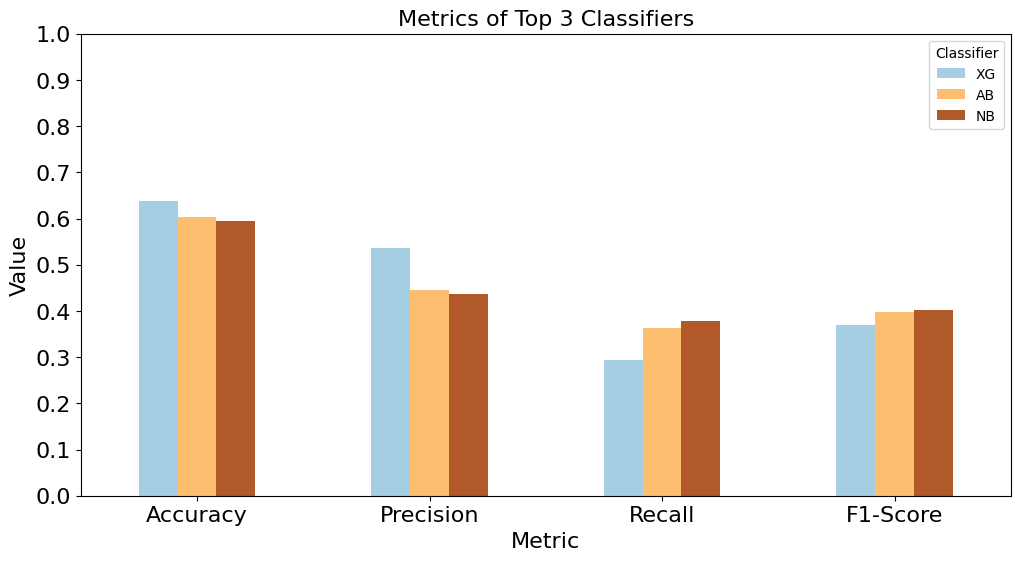

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

performance = pd.DataFrame(rows_list2, columns=['classifier','Accuracy','Precision','Recall','F1-Score'])
# Assuming you have a DataFrame named 'performance' with columns ['classifier', 'Accuracy', 'Precision', 'Recall', 'F1-Score']

# Sort the DataFrame based on a specific metric (e.g., 'Accuracy')
performance = performance.sort_values(by='Accuracy', ascending=False)

# Select the top 3 classifiers
top_3_classifiers = performance.head(3)
print(top_3_classifiers)

# Set 'classifier' column as the index
top_3_classifiers = top_3_classifiers.set_index('classifier')

# Transpose the DataFrame to have metrics as columns
top_3_classifiers = top_3_classifiers.T

# Define custom colors for the bars
#colors = ['red', 'orange', 'green']

# Plot the bar chart with colored bars
ax = top_3_classifiers.plot(kind='bar', figsize=(12, 6), colormap='Paired')

# Set the title and labels
plt.title("Metrics of Top 3 Classifiers",fontsize=16)
plt.xlabel('Metric',fontsize=16)
plt.ylabel('Value',fontsize=16)

# Set the y-axis range and ticks
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, step=0.1),fontsize=16)

# Set the x-axis tick labels rotation to 0 degrees (horizontal)
ax.tick_params(axis='x', rotation=0,labelsize=16)

# Display the legend
plt.legend(title='Classifier')

# Save the plot as a PDF file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Brain_Networks/Results/chart.png', format='png')

# Show the plot
plt.show()